In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization


In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [3]:
df = pd.read_csv("eng_-french.csv")
df.columns = ["en", "fr"]
df.head()

,en,fr
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      175621 non-null  object
 1   fr      175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [5]:
df.describe()

,en,fr
count,175621,175621
unique,123100,165975
top,I can't tell you how happy I am that you've co...,Merci bien.
freq,32,9


In [6]:
df.isna().sum()

en    0
fr    0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.columns.to_list()

['en', 'fr']

In [9]:
df["en"] = df["en"].str.lower()
df["fr"] = df["fr"].str.lower()

In [10]:
en_data = df["en"].values
fr_data =df["fr"].values

In [11]:
en_data[:10]

array(['hi.', 'run!', 'run!', 'who?', 'wow!', 'fire!', 'help!', 'jump.',
       'stop!', 'stop!'], dtype=object)

In [12]:
for i in range(fr_data.shape[0]):
    en_data[i] = "sos " + str(en_data[i]) + " eos"
    fr_data[i] = "sos " + str(fr_data[i]) + " eos"

In [13]:
num_words = 10000
tokenizer_en = Tokenizer(num_words=num_words, filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_en.fit_on_texts(en_data)
englist_sentances = tokenizer_en.texts_to_sequences(en_data)

In [14]:
word_index = tokenizer_en.word_index
print(f"Num words in English: {len(word_index)}")

Num words in English: 14149


In [15]:
tokenizer_fr = Tokenizer(num_words=num_words, filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_fr.fit_on_texts(fr_data)
french_sentences = tokenizer_fr.texts_to_sequences(fr_data)

word_index_fr = tokenizer_fr.word_index
print(f"Num words in French: {len(word_index_fr)}")

Num words in French: 27762


In [16]:
word_index_fr

{'sos': 1,
 'eos': 2,
 'je': 3,
 'de': 4,
 'pas': 5,
 'est': 6,
 'vous': 7,
 'que': 8,
 'il': 9,
 'à': 10,
 'ne': 11,
 'le': 12,
 'la': 13,
 'tu': 14,
 'a': 15,
 'j': 16,
 'ce': 17,
 'n': 18,
 'tom': 19,
 'un': 20,
 'l': 21,
 'ai': 22,
 'nous': 23,
 'en': 24,
 'd': 25,
 'une': 26,
 'les': 27,
 'suis': 28,
 'me': 29,
 'pour': 30,
 'c': 31,
 'elle': 32,
 'qu': 33,
 'faire': 34,
 'ça': 35,
 'dans': 36,
 'y': 37,
 'plus': 38,
 'm': 39,
 'des': 40,
 's': 41,
 'qui': 42,
 'tout': 43,
 'moi': 44,
 'veux': 45,
 'te': 46,
 't': 47,
 'être': 48,
 'fait': 49,
 'était': 50,
 'avec': 51,
 'êtes': 52,
 'mon': 53,
 'du': 54,
 'au': 55,
 'se': 56,
 'si': 57,
 'as': 58,
 'et': 59,
 'avez': 60,
 'sont': 61,
 'cette': 62,
 'ils': 63,
 'es': 64,
 'son': 65,
 'très': 66,
 'peux': 67,
 'votre': 68,
 'temps': 69,
 'pourquoi': 70,
 'été': 71,
 'sur': 72,
 'dit': 73,
 'cela': 74,
 'lui': 75,
 'ma': 76,
 'pense': 77,
 'sais': 78,
 'ici': 79,
 'chose': 80,
 'jamais': 81,
 'où': 82,
 'on': 83,
 'toi': 84,
 'comme

In [17]:
english_sentences = pad_sequences(englist_sentances, maxlen = 7, padding='post', truncating='post')
french_sentences = pad_sequences(french_sentences, maxlen=7, padding='post', truncating='post')

In [18]:
def get_angles(pos, i, embedding_dim):
    """
    Function to compute the angles for positional encoding.
    
    Returns the angle computed
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embedding_dim))
    return pos * angle_rates

In [19]:
def positional_encoding(position, embedding_dim):
    """
    Adds  positional encoding to the Embeddings to be fed to the Transformer model.
    
    Computes a sin and cos of the angles determined by the get_angles() function
    and adds the value computed to an axis of the embeddings.
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)
    
    # apply sin to even indices in the array. ie 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array. ie 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

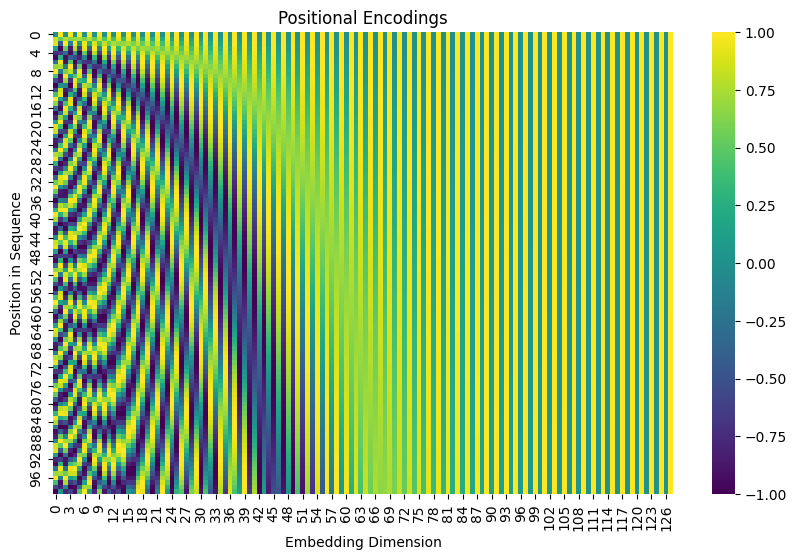

In [20]:
# Generate positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [22]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [23]:
def create_masks(inputs, targets):
    enc_padding_mask = create_padding_mask(inputs)
    dec_padding_mask = create_padding_mask(inputs)
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
    dec_target_padding_mask = create_padding_mask(targets)
    combine_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combine_mask, dec_padding_mask

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    scaled_attention_logits = matmul_qk/scaled_dk
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, key_dim, num_heads, dropout_rate=0.0):
        
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        #  ensure  that the dimension of the embedding can be evenly split across attention heads
        assert key_dim % num_heads == 0 
        self.depth = self.key_dim // self.num_heads
        
        # dense layers to project the input into queries, keys and values
        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)
    
        # dropout layer
        self.dropout = Dropout(dropout_rate)
    
        # dense layer to project the output of the attention heads
        self.dense = Dense(key_dim)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask=None):
        
        batch_size = tf.shape(q)[0]
        
        # Dense on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # split the queries, keys and values into multiple heads
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)
        
        return output, attention_weights

In [26]:
def FeedForward(embedding_dim, fully_connected_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])
    return model

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """
        A single layer of the encoder in a Transformer model.
        
        Args:
            embedding_dim (int): The dimension of the input embeddings.
            num_heads (int): The number of attention heads in the multi-head attention mechanism.
            fully_connected_dim (int): The dimension of the fully connected feedforward network.
            dropout_rate (float, optional): The dropout rate to be applied. Default is 0.1.
        """
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout = Dropout(dropout_rate)
        
        # Feedforward network
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
    def call(self, x, training, mask):
        """
        Forward pass through the encoder layer.

        Args:
            x (tf.Tensor): The input tensor.
            training (bool): Whether the model is in training mode.
            mask: The mask to be applied in multi-head attention.

        Returns:
            tf.Tensor: The output tensor after passing through the encoder layer.
        """
        
        # Apply multi-head self-attention mechanism to input tensor
        attn_output, _ = self.mha(x, x, x, mask)
        
        # Apply first layer normalization and add residual connection
        out1 = self.layernorm1(attn_output + x)
        
        # Apply feedforward network to output of first layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        
        # Apply second layer normalization and add residual connection
        out2 = self.layernorm2(ffn_output + out1)
        
        return out2

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):

        """
        Args:
            num_layers (int): The number of encoder layers.
            embedding_dim (int): The dimension of the input embeddings.
            num_heads (int): The number of attention heads in the multi-head attention mechanism.
            fully_connected_dim (int): The dimension of the fully connected feedforward network.
            input_vocab_size (int): The size of the input vocabulary.
            maximum_position_encoding (int): The maximum position for positional encoding.
            dropout_rate (float, optional): The dropout rate to be applied. Default is 0.1.
        """

        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # Embedding layer
        self.embedding = Embedding(input_vocab_size, embedding_dim)
        
        # Positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        
        # Encoder layers
        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]
        
        # Dropout layer
        self.dropout = Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):

        """
        Forward pass through the encoder.

        Args:
            inputs (tf.Tensor): The input sequence tensor.
            training (bool): Whether the model is in training mode.
            mask: The mask to be applied in multi-head attention.

        Returns:
            tf.Tensor: The encoded sequence tensor.
        """

        # Get the sequence length
        seq_len = tf.shape(inputs)[1]

        # Embed the input sequence
        inputs = self.embedding(inputs)

        # Scale the embeddings by sqrt(embedding_dim)
        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encodings to the input sequence
        inputs += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input sequence
        inputs = self.dropout(inputs, training=training)

        # Pass the input sequence through the encoder layers
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training, mask)

        # Return the encoded sequence
        return inputs

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        """
        Initializes a single decoder layer of the transformer model.
        
        Args:
            embedding_dim: The dimension of the embedding space.
            num_heads: The number of attention heads to use.
            fully_connected_dim: The dimension of the feedforward network.
            rate: The dropout rate for regularization.
        """
        super(DecoderLayer, self).__init__()
        
        # Instantiate two instances of MultiHeadAttention.
        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        
        # Instantiate a fully connected feedforward network.
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)
        
        # Instantiate three layer normalization layers with epsilon=1e-6.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
        # Instantiate a dropout layer for regularization.
        self.dropout3 = Dropout(dropout_rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        """
        Forward pass through the decoder layer.

        Args:
            x (tf.Tensor): The input tensor.
            enc_output (tf.Tensor): The output from the encoder layer.
            training (bool): Whether the model is in training mode.
            look_ahead_mask: The mask for look-ahead in multi-head attention.
            padding_mask: The mask for padding in multi-head attention.

        Returns:
            tf.Tensor: The output tensor after passing through the decoder layer.
            tf.Tensor: The attention weights for the first multi-head attention.
            tf.Tensor: The attention weights for the second multi-head attention.
        """
        
        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        
        # Add the original input to the output of the attention layer and apply layer normalization.
        out1 = self.layernorm1(attn1 + x) 
        
        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        
        # Add the output from the first layer to the output of the second layer and apply layer normalization.
        out2 = self.layernorm2(attn2 + out1)
        
        # Apply the feedforward network to the output of the second layer and apply dropout regularization.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Add the output from the second layer to the output of the feedforward network and apply layer normalization.
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):

        """
        The decoder component of a Transformer model.
    
        Args:
            num_layers (int): The number of decoder layers.
            embedding_dim (int): The dimension of the input embeddings.
            num_heads (int): The number of attention heads to use.
            fully_connected_dim (int): The dimension of the feedforward network.
            target_vocab_size (int): The size of the target vocabulary.
            maximum_position_encoding (int): The maximum position for positional encoding.
            dropout_rate (float, optional): The dropout rate for regularization. Default is 0.1.
        """

        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        
        # create layers
        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        """
        Forward pass through the decoder.

        Args:
            x (tf.Tensor): The input sequence tensor.
            enc_output (tf.Tensor): The output from the encoder layer.
            training (bool): Whether the model is in training mode.
            look_ahead_mask: The mask for look-ahead in multi-head attention.
            padding_mask: The mask for padding in multi-head attention.

        Returns:
            tf.Tensor: The decoded sequence tensor.
            dict: Dictionary containing attention weights for each decoder layer.
        """
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # apply each layer of the decoder
        for i in range(self.num_layers):
            # pass through decoder layer i
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # record attention weights for block1 and block2
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2

        return x, attention_weights

In [31]:
class Transformer(tf.keras.Model):
    
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout_rate=0.1):
        
        """
        The Transformer model.

        Args:
            num_layers (int): The number of layers in the encoder and decoder.
            embedding_dim (int): The dimension of the input embeddings.
            num_heads (int): The number of attention heads to use.
            fully_connected_dim (int): The dimension of the feedforward network.
            input_vocab_size (int): The size of the input vocabulary.
            target_vocab_size (int): The size of the target vocabulary.
            max_positional_encoding_input (int): The maximum positional encoding for the input.
            max_positional_encoding_target (int): The maximum positional encoding for the target.
            dropout_rate (float, optional): The dropout rate for regularization. Default is 0.1.
        """

        super(Transformer, self).__init__()
        
        # Initialize the Encoder and Decoder layers
        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_target, dropout_rate)
        
        # Add a final dense layer to make the final prediction
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        """
        Forward pass through the Transformer.

        Args:
            inp (tf.Tensor): The input sequence tensor.
            tar (tf.Tensor): The target sequence tensor.
            training (bool): Whether the model is in training mode.
            enc_padding_mask: The mask for padding in the encoder.
            look_ahead_mask: The mask for look-ahead in the decoder.
            dec_padding_mask: The mask for padding in the decoder.

        Returns:
            tf.Tensor: The final prediction tensor.
            dict: Dictionary containing attention weights from the decoder.
        """

        # Pass the input sequence through the Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # Pass the target sequence and the output of the Encoder through the Decoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # Pass the output of the Decoder through the final dense layer to get the final prediction
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [32]:
# Set hyperparameters for the Transformer model
embedding_dim = 256  # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 512  # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 4  # number of Transformer blocks in the encoder and decoder stacks
num_heads = 8  # number of heads in the multi-head attention mechanism
dropout_rate = 0.1  # dropout rate for regularization

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(tokenizer_fr.word_index) + 2  # add 2 for the start and end tokens
target_vocab_size = len(tokenizer_en.word_index) + 2  # add 2 for the start and end tokens

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size  # maximum positional encoding value for input sequence
max_positional_encoding_target = target_vocab_size  # maximum positional encoding value for target sequence

# Set the number of epochs and batch size for training
EPOCHS = 50
batch_size = 512

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

In [34]:
transformer = Transformer(num_layers, embedding_dim, num_heads,
                           fully_connected_dim, input_vocab_size, target_vocab_size, 
                           max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [35]:

def loss_function(true_values, predictions):
    """
    Calculate the loss value for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The loss value for the given target sequence.
    """
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Compute the loss value using the loss object
    loss_ = loss_object(true_values, predictions)

    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # Calculate the mean loss value
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_values, predictions):
    """
    Calculate the accuracy for a given target sequence.

    Args:
        true_values (tf.Tensor): The true target sequence.
        predictions (tf.Tensor): The predicted target sequence.

    Returns:
        float: The accuracy value for the given target sequence.
    """
    # Compute the accuracies using the true and predicted target sequences
    accuracies = tf.equal(true_values, tf.argmax(predictions, axis=2))

    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Apply the mask to exclude the padding tokens from the accuracies
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Calculate the mean accuracy value
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define the training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [36]:
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 30), dtype=tf.int64),
    tf.TensorSpec(shape=(batch_size,30), dtype=tf.int64),
]

In [37]:
@tf.function()
def train_step(encoder_input, target):
    """
    Function to perform a single training step.

    Args:
    encoder_input (tf.Tensor): The input tensor for the encoder.
    target (tf.Tensor): The target tensor for the decoder.

    Returns:
    None.
    """

    # Slice the target tensor to get the input for the decoder
    decoder_input = target[:, :-1]

    # Slice the target tensor to get the expected output of the decoder
    expected_output = target[:, 1:]

    # Create masks for the encoder input, decoder input and the padding
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # Perform a forward pass through the model
    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, decoder_input, True, enc_padding_mask, combined_mask, dec_padding_mask)

        # Calculate the loss between the predicted output and the expected output
        loss = loss_function(expected_output, predictions)

    # Calculate gradients and update the model parameters
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update the training loss and accuracy metrics
    train_loss(loss)
    train_accuracy(expected_output, predictions)

In [49]:
for epoch in range(0, EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    current_batch_index = 0

    # iterate through the dataset in batches of batch_size
    for i in range(int(len(english_sentences)/batch_size)):
        # get the input and target batch
        input_batch = tf.convert_to_tensor(np.array(english_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)
        target_batch = tf.convert_to_tensor(np.array(french_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)

        current_batch_index = current_batch_index + batch_size
        # call the train_step function to train the model using the current batch
        train_step(input_batch, target_batch)

    # print the epoch loss and accuracy after iterating through the dataset
    print (f'Epoch {epoch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

Epoch 42 Loss 0.4183 Accuracy 0.8605
Epoch 43 Loss 0.4067 Accuracy 0.8631
Epoch 44 Loss 0.3999 Accuracy 0.8647
Epoch 45 Loss 0.3918 Accuracy 0.8669
Epoch 46 Loss 0.3862 Accuracy 0.8683
Epoch 47 Loss 0.3801 Accuracy 0.8697
Epoch 48 Loss 0.3738 Accuracy 0.8712
Epoch 49 Loss 0.3674 Accuracy 0.8731
Epoch 50 Loss 0.3635 Accuracy 0.8740
Epoch 51 Loss 0.3573 Accuracy 0.8755
Epoch 52 Loss 0.3537 Accuracy 0.8765
Epoch 53 Loss 0.3473 Accuracy 0.8781
Epoch 54 Loss 0.3436 Accuracy 0.8793
Epoch 55 Loss 0.3378 Accuracy 0.8804
Epoch 56 Loss 0.3335 Accuracy 0.8824
Epoch 57 Loss 0.3294 Accuracy 0.8828
Epoch 58 Loss 0.3250 Accuracy 0.8844
Epoch 59 Loss 0.3217 Accuracy 0.8851
Epoch 60 Loss 0.3186 Accuracy 0.8860
Epoch 61 Loss 0.3139 Accuracy 0.8870
Epoch 62 Loss 0.3105 Accuracy 0.8883
Epoch 63 Loss 0.3075 Accuracy 0.8889
Epoch 64 Loss 0.3035 Accuracy 0.8900
Epoch 65 Loss 0.3014 Accuracy 0.8902
Epoch 66 Loss 0.2979 Accuracy 0.8917
Epoch 67 Loss 0.2946 Accuracy 0.8924
Epoch 68 Loss 0.2913 Accuracy 0.8932
E

In [54]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  9216000   
                                                                 
 decoder (Decoder)           multiple                  10270720  
                                                                 
 dense_64 (Dense)            multiple                  3636807   
                                                                 
Total params: 23,123,527
Trainable params: 23,123,527
Non-trainable params: 0
_________________________________________________________________


In [55]:
# save model
# save tokenizer
transformer.save("transformer")

INFO:tensorflow:Assets written to: transformer\assets


INFO:tensorflow:Assets written to: transformer\assets


In [36]:
transformer.load_weights("transformer_weight/model_weights")

In [37]:
# Converting the input sequence to a tensor
text = "hi how are you"
text = "sos " + text.lower() + " eos"
inp_seq = pad_sequences(tokenizer_en.texts_to_sequences([text]), maxlen=10, padding='post')
out_seq = tf.convert_to_tensor([[tokenizer_fr.word_index["sos"]]])
# Creating a mask for the input sequence
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_seq, out_seq)
# # Creating a mask for the output sequence
output_tokens = []
# # Looping until the maximum length of the output sequence is reached or the <end> token is generated
for i in range(100):
    # Calling the Transformer model on the input and output sequences and masks
    output, attn_weights = transformer(inp_seq, out_seq, False, enc_padding_mask, combined_mask, dec_padding_mask)
    # Getting the last token from the output sequence
    last_token = output[:, -1:, :]
    # Getting the token with the highest probability from the last token
    predicted_token = tf.cast(tf.argmax(last_token, axis=-1), tf.int32)
    # Checking if the predicted token is the <end> token
    if predicted_token == tokenizer_fr.word_index["eos"]:
        break
    # Appending the predicted token to the output tokens list
    output_tokens.append(predicted_token[0][0].numpy())
    # Concatenating the predicted token to the output sequence
    out_seq = tf.concat([out_seq, predicted_token], axis=-1)
    # Updating the mask for the output sequence
    decoder_padding_mask, look_ahead_mask = create_padding_mask(out_seq), create_look_ahead_mask(tf.shape(out_seq)[1])
    combined_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)
# Converting the output tokens list to a tensor
output_tokens = tf.convert_to_tensor([output_tokens])
# Detokenizing and decoding the output tokens to get the translation
# translation = tokenizer_fr.sequences_to_texts(output_tokens)[0]

In [38]:
tokenizer_fr.sequences_to_texts(output_tokens.numpy())

['salut comment vas tu\u202f']

In [95]:
tokenizer_en.sequences_to_texts(inp_seq)

['sos hi how are you eos']